In [2]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [3]:
def clean_dataset(df):
    
    variables_to_remove = ['OP_CARRIER_FL_NUM', 'DEP_TIME','ARR_TIME','TAXI_OUT', 'WHEELS_OFF','WHEELS_ON','TAXI_IN', 
                           'CANCELLED', 'CANCELLATION_CODE','DIVERTED','AIR_TIME','CARRIER_DELAY','WEATHER_DELAY',
                           'NAS_DELAY', 'SECURITY_DELAY','LATE_AIRCRAFT_DELAY','CRS_ELAPSED_TIME','ACTUAL_ELAPSED_TIME',
                           'Unnamed: 27','Unnamed: 0']

    df.drop(variables_to_remove, axis = 1, inplace = True)

    df=df.rename(columns={'FL_DATE':'DATE','OP_CARRIER':'AIRLINE','DEST':'DESTIN',
                    'CRS_DEP_TIME':'SCHED_DEPARTURE','DEP_DELAY':'DEPARTURE_DELAY',
                    'CRS_ARR_TIME':'SCHED_ARRIVAL','ARR_DELAY':'ARRIVAL_DELAY'})

    df.dropna(inplace = True)
    
    df['DATE'] = pd.to_datetime(df['DATE'], format = '%Y-%m-%d', errors = 'coerce')
    
    return df


def format_hour(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure

def combine_date(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
    
def transform_hour(df):
    df['SCHED_DEPARTURE'] = df['SCHED_DEPARTURE'].apply(format_hour)
    df['SCHED_ARRIVAL'] = df['SCHED_ARRIVAL'].apply(format_hour)
    
    return df

def create_flight_time(df):    
    lista=[]
    for i,v in df[['DATE','SCHED_DEPARTURE']].iterrows() :   #iteration over rows
    
        try :
            lista.append(datetime.datetime.combine(df['DATE'][i],df['SCHED_DEPARTURE'][i]))
        except:
            lista.append('error')        #if something goes wrong lista appens 'error'

    indices = [i for i, x in enumerate(lista) if x == "error"]   #test of lista to see if it'ok
    print ('Errors during data transformation :  ', len(indices))

    df['DATE_TIME']=lista
    return df

def percentile(df):
    df['DELAY_LEVEL']=df.ARRIVAL_DELAY.rank(pct=True)
    
    return df

def airline_name(df):
    
    df["AIRLINE_NAME"]=df.apply(lambda x: airlines.loc
                           [airlines['CODE'] == x["AIRLINE"],"AIRLINE"].values[0],axis=1)
    return df

def geo (df):
    df=pd.merge(df,airports[['IATA_CODE','LATITUDE','LONGITUDE']],left_on='ORIGIN', right_on='IATA_CODE')
    df=df.rename(columns={'LATITUDE':'OR_LATITUDE','LONGITUDE':'OR_LONGITUDE'})
   
    df=pd.merge(df,airports[['IATA_CODE','LATITUDE','LONGITUDE']],left_on='DESTIN', right_on='IATA_CODE')
    df=df.rename(columns={'LATITUDE':'DEST_LATITUDE','LONGITUDE':'DEST_LONGITUDE'})
    
    return df

def drop_code (df):
    variables_to_remove=['IATA_CODE_x','IATA_CODE_y']
    df=df.drop(variables_to_remove,axis = 1)
    return df

def outlier (df):
    #Outliers 
    # Drop'ARRIVAL_DELAY'>300 and 'ARRIVAL_DELAY'<-50
    outlier1 = df['ARRIVAL_DELAY']>300
    outrmv=df.index[outlier1].tolist()
    df=df.drop(outrmv)
    outlier2 = df['ARRIVAL_DELAY']<-50
    outrmv=df.index[outlier2].tolist()
    df=df.drop(outrmv)
    return df
    

def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

In [4]:
airports = pd.read_csv("dict/airports.csv")
airlines = pd.read_csv('dict/allairlines.csv', sep=';')
airlines_dict = airlines.set_index('CODE')['AIRLINE'].to_dict()
identify_airport = airports.set_index('IATA_CODE')['AIRPORT'].to_dict()
latitude_airport = airports.set_index('IATA_CODE')['LATITUDE'].to_dict()
longitude_airport = airports.set_index('IATA_CODE')['LONGITUDE'].to_dict()

In [5]:
df= pd.read_csv("data/2014.csv")
df_rnd=df.sample(frac = 0.1)
df_rnd.to_csv('sample/sample_2014.csv')

In [6]:
# Primero especificamos un patrón del archivo y lo pasamos como parámetro en la función glob
csv_files = glob.glob('sample/*.csv')
#csv_files = glob.glob('data/*.csv')
# Mostrar el archivo csv_files, el cual es una lista de nombres
print(csv_files)

['sample\\sample_2014.csv']


In [7]:
list_data = []
p = Path('clean/')
# Escribimos un loop que irá a través de cada uno de los nombres de archivo 
# Aplicamos las funciones en el bucle

for filename in csv_files:
    data = pd.read_csv(filename)
    #Cleaning
    data = clean_dataset(data)
    #Datetime Transform
    data = transform_hour(data)
    data = create_flight_time (data)
    #Outliers
    data = outlier(data)
    #Percentile
    data = percentile(data)
    #Airlines names
    data = airline_name(data)
    #Geo
    data = geo(data)
    data = drop_code(data)
    #Saving
    data.to_csv((Path(p, filename)), index=False)
    list_data.append(data)

Errors during data transformation :   0


In [8]:
list_data[0].head(20)

,DATE,AIRLINE,ORIGIN,DESTIN,SCHED_DEPARTURE,DEPARTURE_DELAY,SCHED_ARRIVAL,ARRIVAL_DELAY,DISTANCE,DATE_TIME,DELAY_LEVEL,AIRLINE_NAME,OR_LATITUDE,OR_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE
0,2014-02-09,MQ,GRB,ORD,18:15:00,19.0,19:30:00,18.0,173.0,2014-02-09 18:15:00,0.809996,Envoy Air,44.48507,-88.12959,41.9796,-87.90446
1,2014-01-11,MQ,GRB,ORD,15:15:00,4.0,16:20:00,11.0,173.0,2014-01-11 15:15:00,0.750016,Envoy Air,44.48507,-88.12959,41.9796,-87.90446
2,2014-01-09,MQ,GRB,ORD,18:15:00,103.0,19:30:00,98.0,173.0,2014-01-09 18:15:00,0.970552,Envoy Air,44.48507,-88.12959,41.9796,-87.90446
3,2014-08-03,MQ,GRB,ORD,17:35:00,9.0,18:35:00,3.0,173.0,2014-08-03 17:35:00,0.633371,Envoy Air,44.48507,-88.12959,41.9796,-87.90446
4,2014-04-21,OO,GRB,ORD,09:30:00,-10.0,10:24:00,-5.0,173.0,2014-04-21 09:30:00,0.433745,SkyWest Airlines Inc.,44.48507,-88.12959,41.9796,-87.90446
5,2014-05-18,MQ,GRB,ORD,14:35:00,-9.0,15:30:00,2.0,173.0,2014-05-18 14:35:00,0.613768,Envoy Air,44.48507,-88.12959,41.9796,-87.90446
6,2014-12-19,MQ,GRB,ORD,14:25:00,35.0,15:30:00,36.0,173.0,2014-12-19 14:25:00,0.890987,Envoy Air,44.48507,-88.12959,41.9796,-87.90446
7,2014-03-31,MQ,GRB,ORD,17:35:00,-5.0,18:30:00,11.0,173.0,2014-03-31 17:35:00,0.750016,Envoy Air,44.48507,-88.12959,41.9796,-87.90446
8,2014-02-27,MQ,GRB,ORD,11:40:00,-8.0,12:45:00,-24.0,173.0,2014-02-27 11:40:00,0.036856,Envoy Air,44.48507,-88.12959,41.9796,-87.90446
9,2014-03-06,EV,GRB,ORD,10:50:00,26.0,11:48:00,26.0,173.0,2014-03-06 10:50:00,0.854420,ExpressJet Airlines LLC,44.48507,-88.12959,41.9796,-87.90446


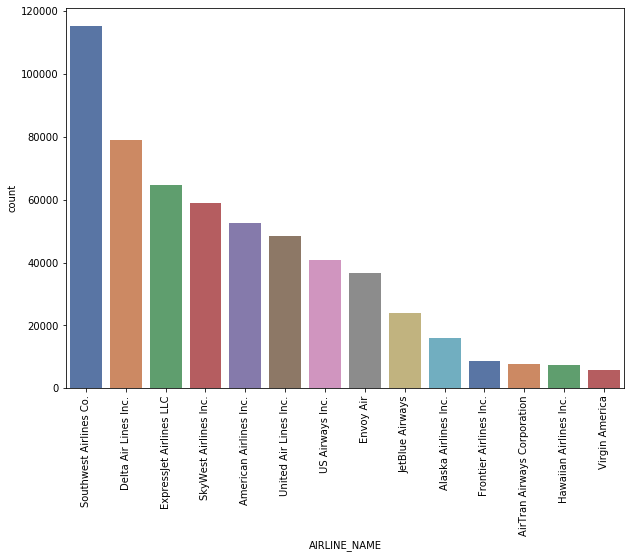

In [9]:
#AIRLINE DECISION
#
plt.figure(figsize=(10,7))
g=sns.countplot(x='AIRLINE_NAME', data=list_data[0], palette="deep", order = list_data[0]['AIRLINE_NAME'].value_counts().index)
g.set_xticklabels(g.get_xticklabels(),rotation=90);

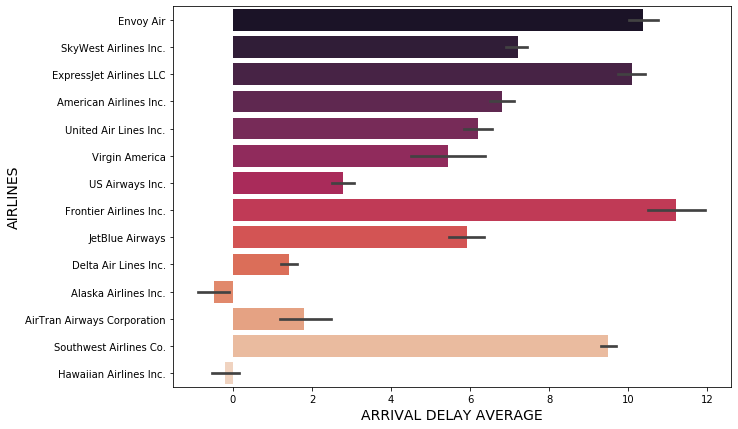

In [10]:
# AIRLINE DELAY AVERAGE
plt.figure(figsize=(10,7))
ax1=sns.barplot(y="AIRLINE_NAME", x="ARRIVAL_DELAY",data=list_data[0],palette='rocket')
plt.xlabel('ARRIVAL DELAY AVERAGE', fontsize=14)
plt.ylabel('AIRLINES', fontsize=14)
plt.show()

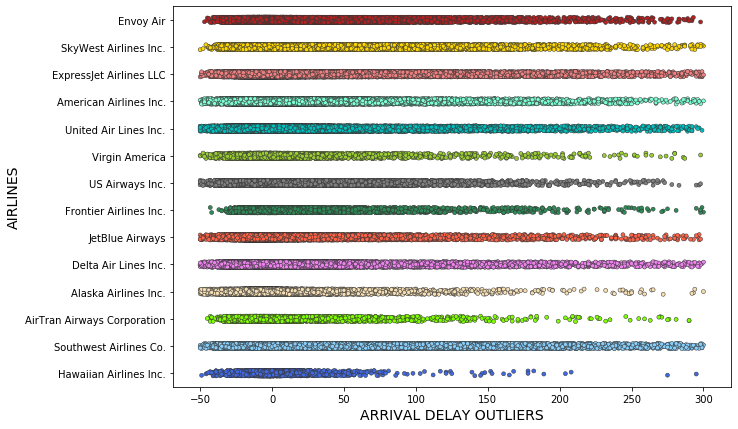

<Figure size 720x504 with 0 Axes>

In [11]:
# CHECKING OUTLIERS
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
plt.figure(figsize=(10,7))
ax2=sns.stripplot(y="AIRLINE_NAME", x="ARRIVAL_DELAY", size = 4, palette = colors,
                    data=list_data[0], linewidth = 0.5,  jitter=True)
plt.xlabel('ARRIVAL DELAY OUTLIERS', fontsize=14)
plt.ylabel('AIRLINES', fontsize=14)
plt.figure(figsize=(10,7))
plt.show()

In [20]:
# American Airlines (AA)
df_AA=list_data[0][list_data[0]['AIRLINE']=='AA']

In [21]:
variables_to_remove=['AIRLINE','AIRLINE_NAME','OR_LATITUDE', 'OR_LONGITUDE', 'DEST_LATITUDE', 
                 'DEST_LONGITUDE','DEPARTURE_DELAY']
df_AA=df_AA.drop(variables_to_remove, axis=1)

In [22]:
df_AA.head(100)

,DATE,ORIGIN,DESTIN,SCHED_DEPARTURE,SCHED_ARRIVAL,ARRIVAL_DELAY,DISTANCE,DATE_TIME,DELAY_LEVEL
264,2014-01-01,EGE,ORD,11:00:00,14:50:00,1.0,1007.0,2014-01-01 11:00:00,0.592701
265,2014-03-22,EGE,ORD,10:55:00,14:45:00,-12.0,1007.0,2014-03-22 10:55:00,0.226896
266,2014-03-14,EGE,ORD,10:55:00,14:45:00,-10.0,1007.0,2014-03-14 10:55:00,0.282301
267,2014-02-03,EGE,ORD,11:00:00,14:50:00,-38.0,1007.0,2014-02-03 11:00:00,0.002695
268,2014-03-27,EGE,ORD,10:55:00,14:45:00,-42.0,1007.0,2014-03-27 10:55:00,0.001104
...,...,...,...,...,...,...,...,...,...
420,2014-02-17,FLL,ORD,08:40:00,11:00:00,13.0,1182.0,2014-02-17 08:40:00,0.770001
421,2014-04-07,FLL,ORD,18:45:00,21:00:00,-8.0,1182.0,2014-04-07 18:45:00,0.342346
422,2014-03-15,FLL,ORD,11:25:00,13:50:00,25.0,1182.0,2014-03-15 11:25:00,0.849852
424,2014-11-08,FLL,ORD,11:55:00,14:20:00,-16.0,1182.0,2014-11-08 11:55:00,0.134262


In [28]:
df_AA['DATE_TIME']=pd.to_datetime(df_AA['DATE_TIME'], format= '%Y-%m-%d %H:%M:%S')
df_AA['MONTH']=[ x.month for x in df_AA['DATE_TIME']]
df_AA['HOUR']=[ x.hour for x in df_AA['DATE_TIME']]

#to date_time
df_AA['SCHED_DEPARTURE']=pd.to_datetime(df_AA['SCHED_DEPARTURE'], format= '%H:%M:%S') #to date_time
conversion = lambda x:x.hour*3600+x.minute*60+x.second 
df_AA['SCHEDULED_DEPARTURE']= np.array([conversion(s) for s in df_AA['SCHED_DEPARTURE']]) #conversion to seconds


df_AA_DATE=df_AA.groupby(df_AA['DATE_TIME']).mean()

df_AA_DATE.head(100)

,ARRIVAL_DELAY,DISTANCE,DELAY_LEVEL,MONTH,HOUR,SCHEDULED_DEPARTURE
DATE_TIME,,,,,,
2014-01-01 06:00:00,-0.750000,844.000000,0.493253,1,6,21600
2014-01-01 06:10:00,-6.000000,1242.000000,0.403657,1,6,22200
2014-01-01 06:20:00,-5.000000,1119.000000,0.433745,1,6,22800
2014-01-01 06:30:00,2.333333,1256.333333,0.549909,1,6,23400
2014-01-01 06:40:00,22.000000,940.500000,0.824992,1,6,24000
...,...,...,...,...,...,...
2014-01-01 19:25:00,-8.000000,175.000000,0.342346,1,19,69900
2014-01-01 19:30:00,46.000000,867.000000,0.915411,1,19,70200
2014-01-01 19:35:00,33.000000,645.500000,0.787777,1,19,70500


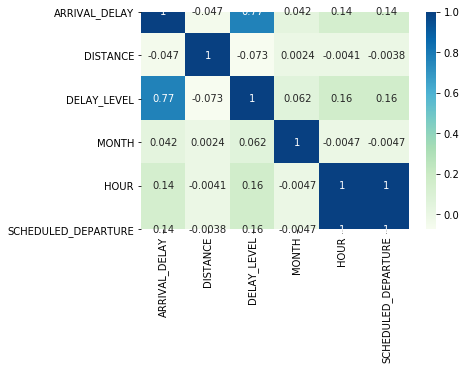

In [27]:
#CORRELATION MATRIX (Pearson Correlation)
corrmat=df_AA_DATE.corr()
ax = sns.heatmap(corrmat, annot=True, cmap="GnBu")

In [ ]:
#CLASIFICACIÓN
#Random forest
#sample aleatorio de un año
#Separamos la columna con la información del delay_level
X = np.array(df_AA.drop(['DELAY_LEVEL'],1))
y = np.array(df_AA['DELAY_LEVEL'])

In [ ]:
#Separamos los datos en train y test, con una proporción de un 70% y 30%, respectivamente.
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3)

In [ ]:
rnd_forest = RandomForestClassifier()
rnd_forest.fit(X_train, y_train)
y_pred_rnd_forest = rnd_forest.predict(X_test)

In [ ]:
#Precisión en la clasificación de los valores de entrenamiento
acc_rnd_forest_train = round(rnd_forest.score(X_train, y_train) * 100, 2)
print (acc_rnd_forest_train)

In [ ]:
# Precisión en la clasificación de los valores de test
acc_rnd_forest = accuracy_score(y_test, y_pred_rnd_forest)
print (acc_rnd_forest*100)

In [ ]:
# Matriz de confusión
confusion_matrix(y_test, y_pred_rnd_forest)